In [1]:
!pip install --quiet lightning

In [2]:
!pip install --quiet transformers

In [9]:
!nvidia-smi

Fri Apr 28 01:24:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    17W /  50W |    542MiB /  4096MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import lightning as pl

In [11]:
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

In [12]:
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

from lightning.pytorch.loggers import TensorBoardLogger
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
from tqdm.auto import tqdm

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
pl.seed_everything(1234)

Global seed set to 1234


1234

In [16]:
df = pd.read_csv("../assets/data/news_summary.csv", encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [17]:
df = df[['text', 'ctext']]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [18]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [19]:
df.shape

(4396, 2)

In [20]:
train_df, test_df = train_test_split(df, test_size=0.1)
print(f"Shape of the Train Set: {train_df.shape}\nShape of the Test Set: {test_df.shape}")

Shape of the Train Set: (3956, 2)
Shape of the Test Set: (440, 2)


In [21]:
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, text_max_token_len=512, summary_max_token_len=128):
        """
        A dataset that represents news articles and their respective summaries.

        Args:
        - data (pd.DataFrame): The data that contains the news articles and their summaries.
        - tokenizer (transformers.tokenization_*) : The tokenizer used to tokenize the text and summary.
        - text_max_token_len (int, optional): The maximum length of the text in terms of tokens. Defaults to 512.
        - summary_max_token_len (int, optional): The maximum length of the summary in terms of tokens. Defaults to 128.
        """
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def __len__(self):
        """
        Returns:
        - The number of samples in the dataset.
        """
        return len(self.data)
    
    def __getitem__(self, index):
        """
        Get a sample from the dataset.

        Args:
        - index (int): The index of the sample to get.

        Returns:
        - A dictionary that contains the following:
            - text (str): The original text of the news article.
            - summary (str): The summary of the news article.
            - text_input_ids (torch.Tensor): The input IDs of the text after tokenization.
            - text_attention_mask (torch.Tensor): The attention mask of the text after tokenization.
            - labels (torch.Tensor): The input IDs of the summary after tokenization.
            - labels_attention_mask (torch.Tensor): The attention mask of the summary after tokenization.
        """
        data_row = self.data.iloc[index]
        text = data_row["text"]

        # Encode the text
        text_encoding = self.tokenizer(
            text, 
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Encode the summary
        summary_encoding = self.tokenizer(
            data_row["summary"], 
            max_length=self.summary_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Modify the labels so that the model knows which tokens to predict
        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100
        
        return {
            'text': text,
            'summary': data_row['summary'],
            'text_input_ids': text_encoding['input_ids'].flatten(),
            'text_attention_mask': text_encoding['attention_mask'].flatten(),
            'labels': labels.flatten(),
            'labels_attention_mask': summary_encoding["attention_mask"].flatten()
        }


This is a Python class named "NewsDataset", which extends the PyTorch "Dataset" class, and it takes as input a pandas DataFrame object containing news articles data, a tokenizer object, and maximum token lengths for both the text and the summary.

The class has three methods:

- __init__(self, data, tokenizer, text_max_token_len=512, summary_max_token_len=128): This method initializes the class object and sets the instance variables. It takes the following arguments:
    - data: a pandas DataFrame object containing news articles data, with columns "text" and "summary".
    - tokenizer: a tokenizer object from the Hugging Face library that is used to tokenize the text and summary data.
    - text_max_token_len: an optional integer that sets the maximum number of tokens to use for the text data.
    - summary_max_token_len: an optional integer that sets the maximum number of tokens to use for the summary data.
- __len__(self): This method returns the length of the dataset.

- __getitem__(self, index): This method returns a dictionary of tokenized data for a single data point in the dataset. It takes an index as input and does the following steps:

    - Retrieve the data at the given index from the pandas DataFrame object.
    - Tokenize the text using the tokenizer object and set the maximum token length.
    - Tokenize the summary using the tokenizer object and set the maximum token length.
    - Set the labels for the summary using the "input_ids" tokenization.
    - Replace all 0 values in the labels with -100.
    - Return a dictionary containing the original text, the summary, the tokenized text input IDs, the attention mask for the text input, the labels for the summary, and the attention mask for the summary input.

In [22]:
class NewsDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_df,
                 test_df,
                 tokenizer,
                 batch_size=8,
                 text_max_token_len=152,
                 summary_max_token_len=128):
        """
        Initializes the NewsDataModule.
        
        Args:
        - train_df (pandas.DataFrame): the training dataset
        - test_df (pandas.DataFrame): the testing dataset
        - tokenizer (transformers.PreTrainedTokenizer): the tokenizer to be used
        - batch_size (int): the batch size
        - text_max_token_len (int): the maximum number of tokens for the text
        - summary_max_token_len (int): the maximum number of tokens for the summary
        """
        super().__init__()
        
        self.train_df = train_df
        self.test_df = test_df
        
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def setup(self, stage=None):
        """
        Sets up the dataset.
        """
        self.train_dataset = NewsDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
        
        self.test_dataset = NewsDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
    
    def train_dataloader(self):
        """
        Returns the DataLoader for the training set.
        """
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
    
    def test_dataloader(self):
        """
        Returns the DataLoader for the testing set.
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
    
    def val_dataloader(self):
        """
        Returns the DataLoader for the validation set, which is the same as the testing set.
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

This is a Python class named "NewsDataModule", which extends the PyTorch Lightning "LightningDataModule" class, and it takes as input two pandas DataFrame objects containing news articles data for the train and test sets, a tokenizer object, and maximum token lengths for both the text and the summary.

The class has five methods:

- __init__(self, train_df, test_df, tokenizer, batch_size=8, text_max_token_len=152, summary_max_token_len=128): This method initializes the class object and sets the instance variables. It takes the following arguments:
    - train_df: a pandas DataFrame object containing news articles data for the training set, with columns "text" and "summary".
    - test_df: a pandas DataFrame object containing news articles data for the test set, with columns "text" and "summary".
    - tokenizer: a tokenizer object from the Hugging Face library that is used to tokenize the text and summary data.
    - batch_size: an optional integer that sets the batch size for the dataloaders.
    - text_max_token_len: an optional integer that sets the maximum number of tokens to use for the text data.
    - summary_max_token_len: an optional integer that sets the maximum number of tokens to use for the summary data.
- setup(self, stage=None): This method sets up the datasets for the train, validation, and test sets. It takes an optional stage argument that is not used in this code.
    - Creates the train dataset by initializing a NewsDataset object with the train DataFrame, tokenizer, and maximum token lengths.
    - Creates the test dataset by initializing a NewsDataset object with the test DataFrame, tokenizer, and maximum token lengths.
- train_dataloader(self): This method returns a DataLoader object for the train dataset.
    - Returns a DataLoader object with the train dataset, the batch size, and shuffles the data.

Others are same as train_dataloader(self)

In [23]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

/home/volt/.local/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [24]:
text_token_counts = [len(tokenizer.encode(row["text"])) for _, row in train_df.iterrows()]
summary_token_counts = [len(tokenizer.encode(row["summary"])) for _, row in train_df.iterrows()]


Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors


In the above code, calculate the number of tokens in each text and summary data in the training set using the provided tokenizer object, and stores the results in separate lists. These token counts can be used to determine appropriate maximum token lengths for the text and summary when setting up the NewsDataModule object.

* Create Two empty lists named text_token_counts and summary_token_counts. It then iterates over each row of the train_df DataFrame using the iterrows() method.

* For each row, it calculates the number of tokens in the "text" column by calling the encode() method of the tokenizer object and passing in the text as an argument. The number of tokens is then appended to the text_token_counts list.

* Similarly, it calculates the number of tokens in the "summary" column by calling the encode() method of the tokenizer object and passing in the summary as an argument. The number of tokens is then appended to the summary_token_counts list.


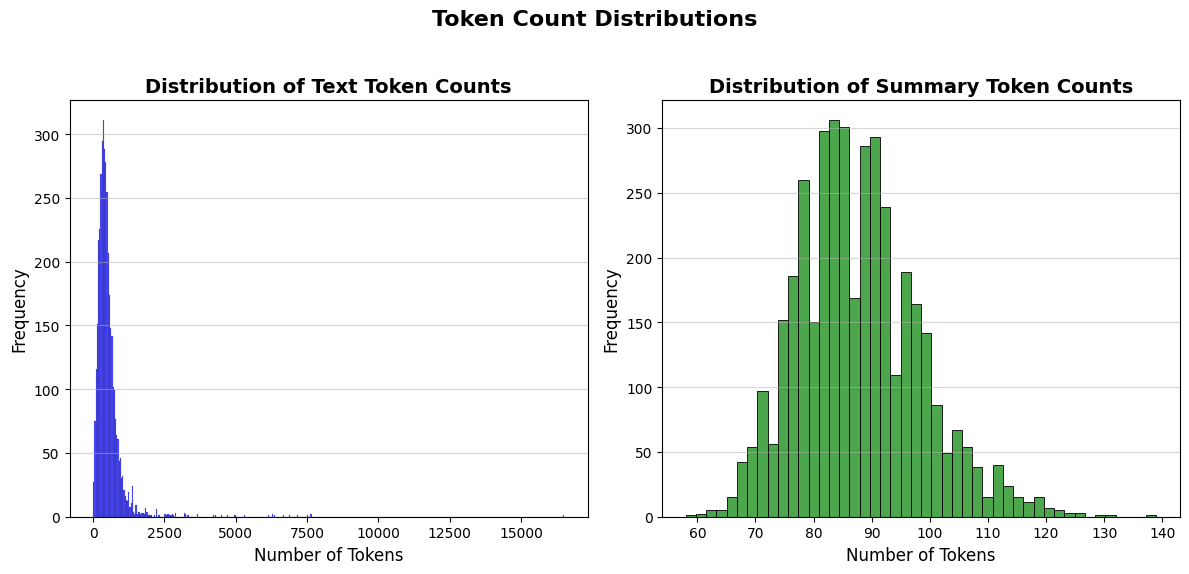

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(text_token_counts, ax=ax1, color='blue', alpha=0.7)
ax1.set_title("Distribution of Text Token Counts", fontsize=14, fontweight='bold')
ax1.set_xlabel("Number of Tokens", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.grid(axis='y', alpha=0.5)

sns.histplot(summary_token_counts, ax=ax2, color='green', alpha=0.7)
ax2.set_title("Distribution of Summary Token Counts", fontsize=14, fontweight='bold')
ax2.set_xlabel("Number of Tokens", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.grid(axis='y', alpha=0.5)

plt.suptitle("Token Count Distributions", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [26]:
N_EPOCHS = 1
BATCH_SIZE=8

data_module = NewsDataModule(
    train_df, 
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE
    
)

Model

In [27]:
class SummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits

    def shared_step(self, batch, batch_idx, stage):
        input_ids = batch['text_input_ids']
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, _ = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log(f"{stage}_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)


- The __init__ method initializes the T5 model by loading the pre-trained weights from the specified MODEL_NAME and setting return_dict=True to enable the module to return a dictionary of model outputs.

- The forward method takes input_ids, attention_mask, decoder_attention_mask, and labels as input and performs forward propagation of the T5 model. The output of the method is a tuple of the loss and logits.

- The shared_step method is a helper function that takes in a batch, batch index, and a stage (train, val, or test) and computes the loss for that batch. It uses the forward method to get the loss and logs the loss to the PyTorch Lightning logger using self.log(). The method returns the loss.

- The training_step, validation_step, and test_step methods call the shared_step method with the appropriate stage and return the loss.

- The configure_optimizers method sets up the optimizer used to update the model's parameters during training. In this case, it returns an AdamW optimizer with a learning rate of 0.0001.

In [28]:
model_1 = SummaryModel()

In [29]:
%load_ext tensorboard
%tensorboard --logdir ./kaggle/working/lighting_logs

In [31]:
callbacks = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints",
    filename="base-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name="news_summary")

trainer= Trainer(
    logger=logger,
    callbacks=callbacks,
    max_epochs=N_EPOCHS,
    # gpus=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(model_1, data_module)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.81 GiB total capacity; 2.89 GiB already allocated; 44.81 MiB free; 3.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
best_model = SummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
best_model.freeze()

In [ ]:
def encode_text(text):
    # Encode the text using the tokenizer
    encoding = tokenizer.encode_plus(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding["input_ids"], encoding["attention_mask"]

def generate_summary(input_ids, attention_mask):
    # Generate a summary using the best model
    generated_ids = best_model.model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    return generated_ids

def decode_summary(generated_ids):
    # Decode the generated summary
    summary = [tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
               for gen_id in generated_ids]
    return "".join(summary)

def summarize(text):
    input_ids, attention_mask = encode_text(text)
    generated_ids = generate_summary(input_ids, attention_mask)
    summary = decode_summary(generated_ids)
    return summary


This code defines a Python function named summarize that generates a summary of the input text using a pre-trained T5 Transformer model and tokenizer. Here is a step-by-step explanation of the code:

The summarize function takes a single argument text which represents the input text to be summarized.
The tokenizer function is called to encode the text input. The max_length parameter specifies the maximum length of the input sequence to be generated by the tokenizer. The padding parameter specifies whether to pad the input sequence to the maximum length. The truncation parameter specifies whether to truncate the input sequence if it exceeds the maximum length. The return_attention_mask parameter specifies whether to return the attention mask tensor along with the input tensor. The add_special_tokens parameter specifies whether to add special tokens to the input sequence. The return_tensors parameter specifies the format of the returned tensor, in this case, PyTorch tensor.
The generate method of the pre-trained T5 Transformer model is called to generate a summary of the input text. The input_ids parameter specifies the token IDs of the input sequence. The attention_mask parameter specifies the attention mask tensor of the input sequence. The max_length parameter specifies the maximum length of the summary to be generated. The num_beams parameter specifies the number of beams to use in beam search. The repetition_penalty parameter specifies the penalty to apply to repeated tokens in the generated summary. The length_penalty parameter specifies the penalty to apply to the length of the generated summary. The early_stopping parameter specifies whether to stop generating the summary as soon as all beam hypotheses reach the end of the sequence or not.
The decode method of the tokenizer is called to convert the generated token IDs to text format. The skip_special_tokens parameter specifies whether to skip special tokens in the generated text. The clean_up_tokenization_spaces parameter specifies whether to remove leading and trailing white spaces from the generated text.
The generated text is joined using the join method of the string object and returned as the output of the summarize function.
Overall, this code uses the pre-trained T5 Transformer model and tokenizer to generate a summary of the input text. The generate method of the model is used to generate the summary, and the decode method of the tokenizer is used to convert the generated token IDs to text format. The summarize function provides an easy-to-use API for summarizing text using a pre-trained T5 Transformer model.

In [ ]:
sample_row = test_df.iloc[3]
text = sample_row["text"]
model_summary = summarize(text)

In [ ]:
text

In [ ]:
sample_row["summary"]

In [ ]:
model_summary